In [22]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
import matplotlib.patches as mpatches
import geopandas as gpd
from rasterio.mask import mask
import shapely.geometry
from itertools import combinations
import warnings

warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches


In [23]:
def read_raster(filepath):
    with rasterio.open(filepath) as src:
        return src.read(1), src.transform, src.meta


In [24]:
def clip_raster_to_aoi(filepath, bbox_geojson):
    bbox_geom = gpd.GeoDataFrame.from_features(
        [{"type": "Feature", "properties": {}, "geometry": bbox_geojson}],
        crs="EPSG:4326",
    )
    with rasterio.open(filepath) as src:
        src_crs = src.crs if src.crs else "EPSG:4326"
        bbox_geom = bbox_geom.to_crs(crs=src_crs)
        intersection = bbox_geom.unary_union.intersection(
            shapely.geometry.box(*src.bounds)
        )
        if not intersection.is_empty:
            out_image, out_transform = mask(src, shapes=[intersection], crop=True)
            out_meta = src.meta.copy()
            out_meta.update(
                {
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "nodata": np.nan,
                }
            )
            return out_image.squeeze(), out_transform, out_meta


In [25]:
def align_raster(
    source_array,
    source_transform,
    source_meta,
    target_transform,
    target_crs,
    template_shape,
):
    aligned_array = np.empty(template_shape)
    reproject(
        source=source_array,
        destination=aligned_array,
        src_transform=source_transform,
        src_crs=source_meta["crs"],
        dst_transform=target_transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest,
    )
    return aligned_array


Clipped(2001)_meter.tif


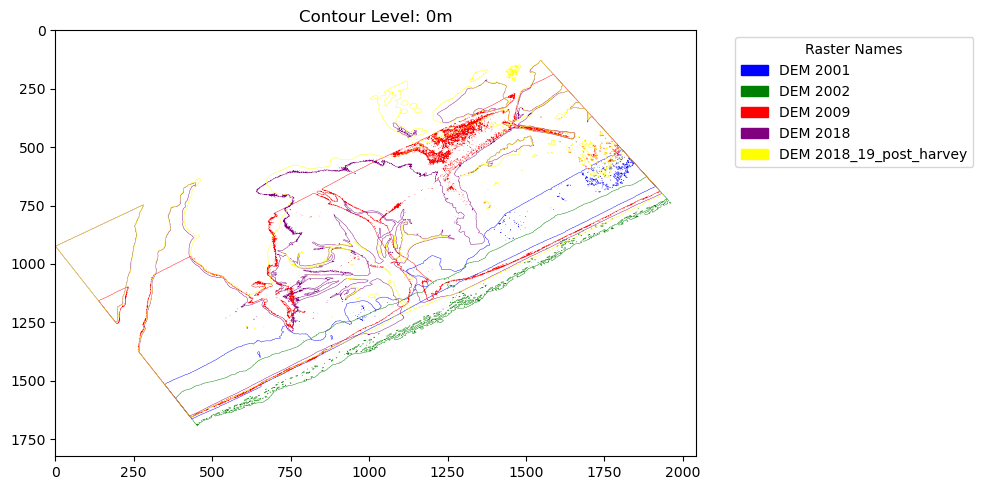

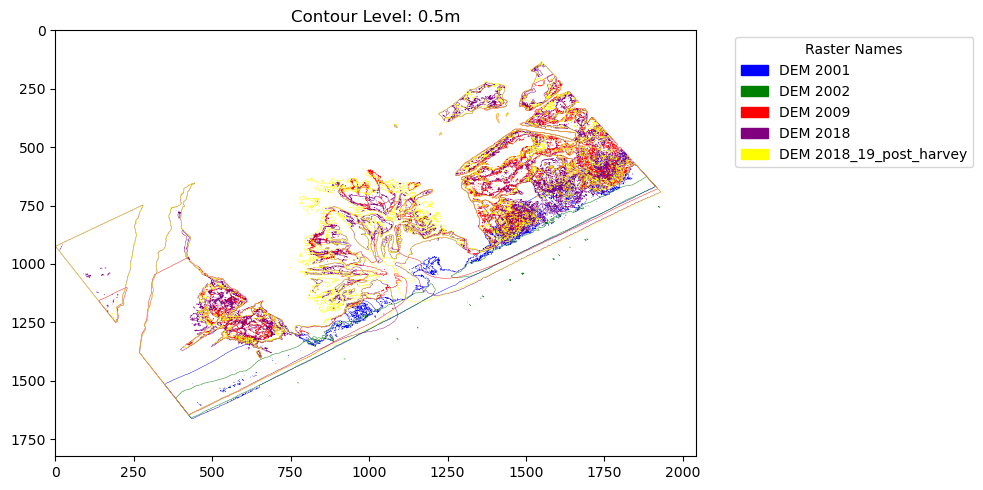

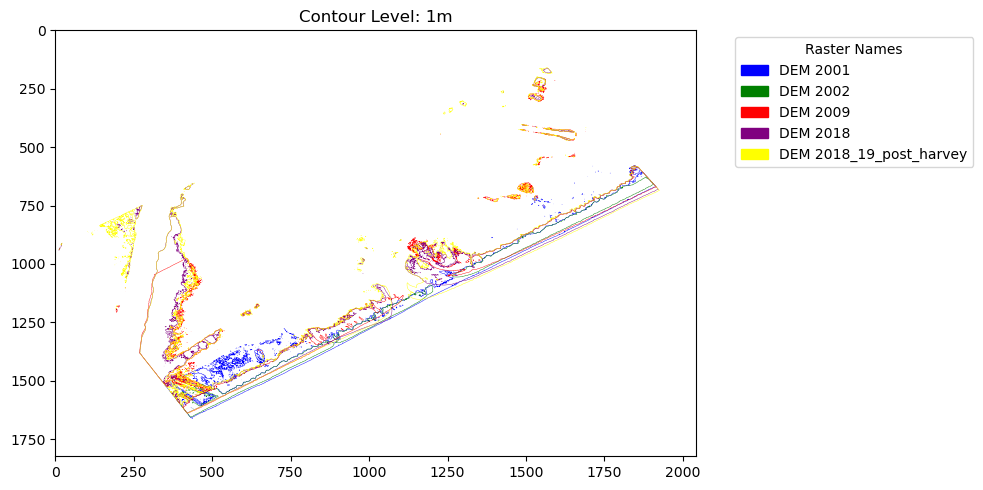

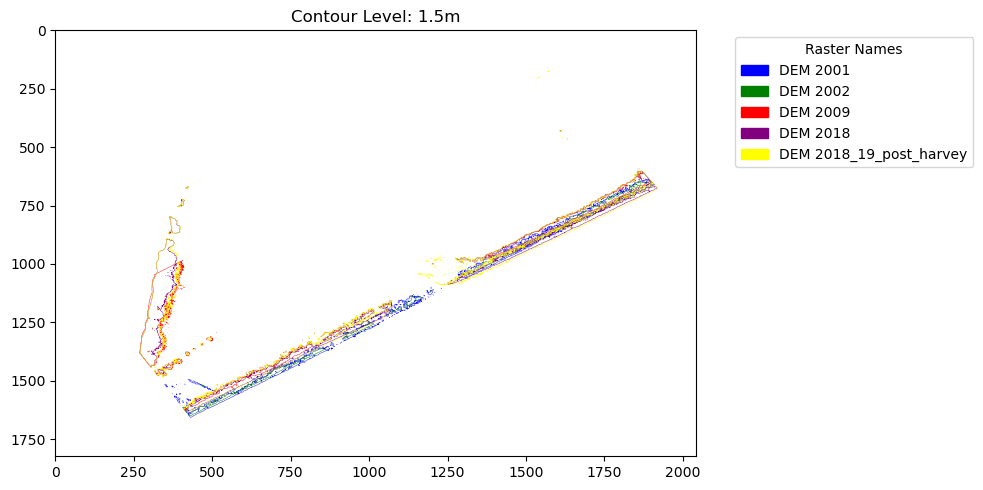

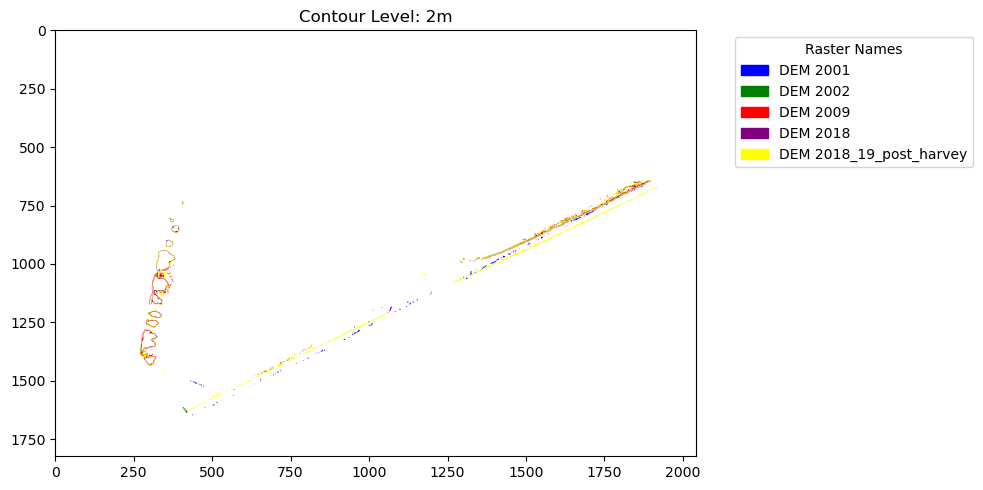

In [26]:
def main(rasters_dict, bbox_geojson):
    rasters = []
    names = []
    first_array_shape = None
    first_transform = None
    first_meta = None

    for path, name in rasters_dict.items():
        if first_array_shape is None:
            print(path)
            array, transform, meta = clip_raster_to_aoi(path, bbox_geojson)
            first_array_shape = array.shape
            first_transform = transform
            first_meta = meta
        else:
            array, transform, meta = clip_raster_to_aoi(path, bbox_geojson)
            array = align_raster(
                array,
                transform,
                meta,
                first_transform,
                first_meta["crs"],
                first_array_shape,
            )
        rasters.append(array)
        names.append(name)

    plot_results(rasters, names)


def plot_results(rasters, names):
    levels = [0, 0.5, 1, 1.5, 2]
    colors = ["blue", "green", "red", "purple", "yellow"]
    for level in levels:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        legend_handles = []
        for i, (array, name) in enumerate(zip(rasters, names)):
            contour = ax.contour(
                array,
                levels=[level],
                colors=[colors[i % len(colors)]],
                linewidths=0.3,
                label=name,
            )
            legend_handles.append(
                mpatches.Patch(color=colors[i % len(colors)], label=name)
            )
        ax.invert_yaxis()
        ax.set_title(f"Contour Level: {level }m")
        ax.legend(
            handles=legend_handles,
            title="Raster Names",
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )
        plt.tight_layout()
        plt.savefig(f"contour_{level}.svg")
        plt.show()


# Assuming the existence of required functions like clip_raster_to_aoi, align_raster, etc.

rasters_dict = {
    "Clipped(2001)_meter.tif": "DEM 2001",
    "Clipped(2002)_meter.tif": "DEM 2002",
    # 'Clipped(2006)_meter.tif': 'DEM 2006',
    "Clipped(2009)_meter.tif": "DEM 2009",
    # 'Clipped(2016)_meter.tif': 'DEM 2016',
    "Clipped(2018)_meter.tif": "DEM 2018",
    "(Clipped)2018_19_post_harvey_meter.tif": "DEM 2018_19_post_harvey",
}

bbox_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [-95.514107383931105, 28.837294991608498],
            [-95.542191067157702, 28.82310160914],
            [-95.533023536824004, 28.807894014576299],
            [-95.5039012207138, 28.822751403692301],
            [-95.514107383931105, 28.837294991608498],
        ]
    ],
}

main(rasters_dict, bbox_geojson)
